In [128]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import get_window

from PIL import Image

In [129]:
def show_image (image):
    plt.imshow(image, cmap="gray")
    plt.title("Imagem Original em Tons de Cinza")
    plt.axis('off')

    plt.show()

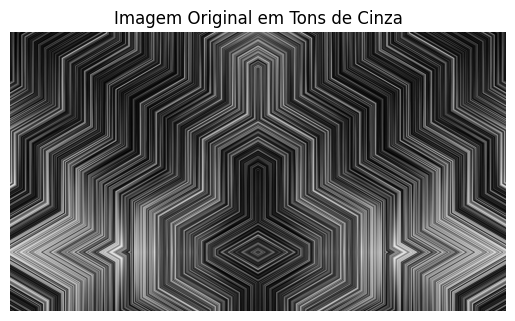

In [130]:
# Nome do arquivo de imagem
img_name = '2560x1440.jpg'

# Carregando a imagem com PIL
img = Image.open(img_name).convert("L")
img = np.array(img, dtype=float)

show_image(img)
# Convertendo a imagem para escala de cinza
# img_gray = img.convert("L")

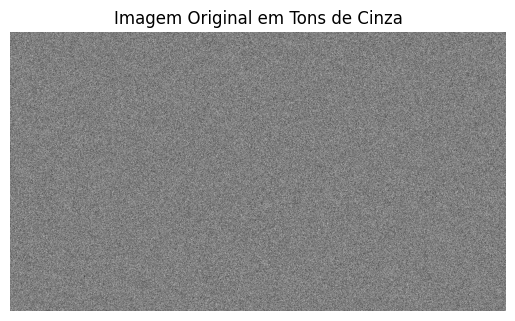

In [127]:
# img = np.random.randint(low = 0, high = 256, size=(1440, 2560))
# show_image(img)

In [131]:
# Maior potência de 2 que ≤ L/8 (L: tamanho da entrada)
def choose_window_size (input_size):
    n = 1
    while (True):
        next_n = n*2
        if next_n > input_size/8:
            return n
        n = next_n

def get_qnt_padding(input_size, window_size):
    stride = window_size // 2
    qnt_tiles = int(np.ceil((input_size - window_size) / stride)) + 1
    tamanho_total = (qnt_tiles - 1) * stride + window_size
    padding = tamanho_total - input_size
    return padding

In [132]:
window_size_w = choose_window_size(img.shape[1])
window_size_h = choose_window_size(img.shape[0])

stride_w = window_size_w // 2
stride_h = window_size_h // 2

window_w = get_window("hann", window_size_w)
window_h = get_window("hann", window_size_h)

window_2d = np.outer(window_h, window_w)

In [133]:
pad_w = get_qnt_padding(img.shape[1], window_size_w)
pad_h = get_qnt_padding(img.shape[0], window_size_h)

padded_img = np.pad(img, ((0,pad_h), (0,pad_w)))

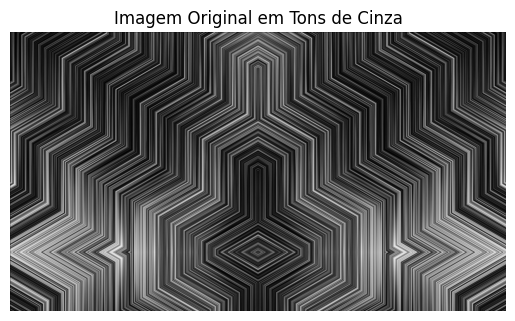

In [134]:
out = np.zeros_like(padded_img, dtype=np.float64)
weights = np.zeros_like(padded_img)

for w_start_i in range(0, padded_img.shape[0] - window_size_h + 1, stride_h):
    for w_start_j in range(0, padded_img.shape[1] - window_size_w + 1, stride_w):
        w_end_i = w_start_i + window_size_h
        w_end_j = w_start_j + window_size_w

        tile = padded_img[w_start_i:w_end_i, w_start_j:w_end_j].copy()
        tile *= window_2d

        F = np.fft.fft2(tile)

        # Processamento da imagem pode ser aplicado aqui

        inverse = np.fft.ifft2(F).real

        out[w_start_i:w_end_i, w_start_j:w_end_j] += inverse
        weights[w_start_i:w_end_i, w_start_j:w_end_j] += window_2d

# normalizando
img_after = np.zeros_like(out)
mask = weights > 0
img_after[mask] = out[mask] / weights[mask]

# removendo as bordas adicionadas com o padding
img_after = img_after[:img.shape[0], :img.shape[1]]
show_image(img_after)